<a href="https://colab.research.google.com/github/thunder913/Deep-Learning/blob/main/stocks_deep_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import kagglehub
import numpy as np
import os
import pandas as pd
import kagglehub
import matplotlib.pyplot as plt
import pickle
import pdb
import tensorflow as tf
import keras

from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Embedding, LSTM, Dropout, Dense, Concatenate, BatchNormalization, AdditiveAttention, Multiply, Flatten
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Stocks LSTM Prediction

In [3]:
google_drive_path = 'drive/MyDrive/DL_Pickles/'

path = kagglehub.dataset_download("tsaustin/us-historical-stock-prices-with-earnings-data")

stock_prices_path = f"{path}/stocks_latest/stock_prices_latest.csv"

stock_data_path = f"./{google_drive_path}/stock_data_processed.pkl"
scaler_path = f"./{google_drive_path}/scalers.pkl"

data_path = f"./{google_drive_path}/scaled_stock_data.pkl"  # Path to store scaled DataFrame

In [4]:
def calculate_rsi(group, period = 14):
    delta = group['close_adjusted'].diff()

    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=period, min_periods=1).mean()
    avg_loss = loss.rolling(window=period, min_periods=1).mean()

    rs = avg_gain / np.where(avg_loss != 0, avg_loss, 1)

    group['RSI'] = 100 - (100 / (1 + rs))

    return group

def calculate_macd(group, short_window=12, long_window=26, signal_window=9):
    # Calculate EMA short and long
    ema_short = group['close_adjusted'].ewm(span=short_window, adjust=False).mean()
    ema_long = group['close_adjusted'].ewm(span=long_window, adjust=False).mean()

    # Calculate MACD and Signal Line
    group['MACD'] = ema_short - ema_long
    group['Signal_Line'] = group['MACD'].ewm(span=signal_window, adjust=False).mean()

    return group

In [5]:
def get_peak_price_and_days_ago(df):
    """
    Calculate the peak price over a rolling 90-day window and determine the number of days
    since the peak price for each row in the DataFrame.
    """

    #df['peak_price'] = df['close'].rolling(window=90, min_periods=1).max()
    #peak_day_index = df['close'].rolling(window=90, min_periods=1).apply(lambda x: (len(x) - 1 - x.argmax()), raw=False)
    #df['peak_days_ago'] = peak_day_index.fillna(0).astype(int)  # Fill NaN for rows that don't have enough data
    return df

def process_ticker_data(df):
    """
    Add historical price features for specific days ago for each stock (grouped by ticker).
    Also calculate the peak price and days since the peak price for each stock.
    """

    print('Calculated RSI')
    # Calculate RSI (14-day by default)
    df = df.groupby('ticker', group_keys=False).apply(calculate_rsi)

    print('Calculated moving averages')
    # Add moving averages
    moving_average_windows = [5, 10, 20, 50, 100, 200]  # Specify moving average windows
    for window in moving_average_windows:
        df[f'{window}_day_MA'] = df.groupby('ticker')['close_adjusted'].rolling(window=window, min_periods=1).mean().reset_index(level=0, drop=True)

    print('Calculated MACD')
    # Calculate MACD and Signal Line

    df = df.groupby('ticker', group_keys=False).apply(calculate_macd)

    print('Calculated price days ago')
    # Add columns for prices X days ago
    #for days in [1,2,3,4,5, 10, 15, 30, 60, 90]:
    #    df[f'price_{days}_days_ago'] = df.groupby('ticker')['close_adjusted'].shift(days)

    df = df.groupby('ticker', group_keys=False).apply(get_peak_price_and_days_ago)

    # Remove the first 200 rows for each ticker
    df = df.groupby('ticker').apply(lambda group: group.iloc[200:]).reset_index(drop=True)

    return df

In [6]:
def scale_stock_data(stock_data_tidy, numerical_columns):
    """
    Scales numerical columns for each stock ticker independently using MinMaxScaler.

    - Loads existing scalers and scaled data if available.
    - Trains and saves new scalers & scaled data if they don’t exist.
    - Returns a new scaled DataFrame without modifying the original.

    Args:
        stock_data_tidy: The input stock data.
        numerical_columns: The numerical column names, that need to be rescaled.

    Returns:
        pd.DataFrame: The scaled stock data.
    """

    if os.path.exists(scaler_path) and os.path.exists(data_path):
        print("Loading existing scalers and scaled data...")

        # Load scalers
        with open(scaler_path, "rb") as f:
            scalers = pickle.load(f)

        # Load scaled stock data
        with open(data_path, "rb") as f:
            new_data_tidy_rescaled = pickle.load(f)

        print("Loaded scalers and scaled data from file.")
        return new_data_tidy_rescaled

    # If files don't exist, compute scalers and scaled data
    print("Recalculating scalers and scaled data...")
    scalers = {}  # Create scalers dictionary
    new_data_tidy_rescaled = []  # Store transformed data

    for ticker in stock_data_tidy['ticker_encoded'].unique():
        print(f"Processing ticker: {ticker}")

        ticker_data = stock_data_tidy[stock_data_tidy['ticker_encoded'] == ticker].copy()

        scaler = MinMaxScaler()
        scalers[ticker] = scaler.fit(ticker_data[numerical_columns])

        ticker_data.loc[:, numerical_columns] = scaler.transform(ticker_data[numerical_columns])

        new_data_tidy_rescaled.append(ticker_data)

    new_data_tidy_rescaled = pd.concat(new_data_tidy_rescaled, ignore_index=True)

    with open(scaler_path, "wb") as f:
        pickle.dump(scalers, f)

    with open(data_path, "wb") as f:
        pickle.dump(new_data_tidy_rescaled, f)

    print("Saved scalers and scaled data to file.")

    return new_data_tidy_rescaled

In [7]:
def getTidiedStockData():
    """
    Read and tidy the stock data dataset. If the processed stock data already exists as a pickle file,
    it loads and returns the data. Otherwise, it processes the raw stock data, cleans it, adds features,
    and saves the tidy data to a pickle file for future use.
    """

    # Check if the file exists
    if os.path.exists(stock_data_path):
        print('found pickle')
        return pd.read_pickle(stock_data_path)

    # Read the basic data and some tidying
    stock_data = pd.read_csv(stock_prices_path)
    stock_data_tidy = stock_data

    stock_data_tidy.date = pd.to_datetime(stock_data_tidy.date)
    stock_data_tidy = stock_data_tidy.rename(columns={'symbol': 'ticker'})
    stock_data_tidy = stock_data_tidy.drop(columns=['split_coefficient'])

    stock_data_tidy = stock_data_tidy.sort_values(by=['ticker', 'date'], ascending=[True, True])

    stock_data_tidy = process_ticker_data(stock_data_tidy)
    stock_data_tidy = stock_data_tidy.drop(columns=['open', 'high', 'low', 'close', 'volume'])

    # Encode labels
    le = LabelEncoder()
    stock_data_tidy['ticker_encoded'] = le.fit_transform(stock_data_tidy['ticker'])

    stock_data_tidy['day_of_week'] = stock_data_tidy['date'].dt.dayofweek

    stock_data_tidy = scale_stock_data(stock_data_tidy, numerical_columns)

    stock_data_tidy.to_pickle(stock_data_path)

    return stock_data_tidy

In [8]:
numerical_columns = [
    'close_adjusted', 'RSI', '5_day_MA', '10_day_MA',
    '20_day_MA', '50_day_MA', '100_day_MA', '200_day_MA',
    'MACD', 'Signal_Line'
]

stock_data_tidy = getTidiedStockData()

with open(scaler_path, "rb") as f:
    scalers = pickle.load(f)

found pickle


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.6.1 when using version 1.6.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [9]:
def plot_stock_chart(stock_data_tidy, ticker, start_date=None, end_date=None):
    """
    Plot a stock chart for a specific ticker.

    Parameters:
        stock_data_tidy (DataFrame): The DataFrame containing stock data.
        ticker (str): The ticker to plot.
        start_date (str): Optional start date (e.g., '2023-01-01').
        end_date (str): Optional end date (e.g., '2023-12-31').
    """
    # Filter data for the specific ticker and date range
    stock_data_tidy['date'] = pd.to_datetime(stock_data_tidy['date'])
    filtered_data = stock_data_tidy[stock_data_tidy['ticker'] == ticker]

    if start_date:
        filtered_data = filtered_data[filtered_data['date'] >= start_date]
    if end_date:
        filtered_data = filtered_data[filtered_data['date'] <= end_date]

    # Ensure data is sorted by date
    filtered_data = filtered_data.sort_values(by='date')

    # Plot the stock chart
    plt.figure(figsize=(12, 6))
    plt.plot(filtered_data['date'], filtered_data['close_adjusted'], label='Close Price', color='blue', linewidth=2)

    # Add moving averages if they exist in the DataFrame
    for col in ['5_day_MA', '10_day_MA', '50_day_MA']:
        if col in filtered_data.columns:
            plt.plot(filtered_data['date'], filtered_data[col], label=col, linestyle='--')

    # Chart settings
    plt.title(f"Stock Chart for {ticker}", fontsize=16)
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Price", fontsize=12)
    plt.legend(loc="best", fontsize=10)
    plt.grid(alpha=0.3)
    plt.show()

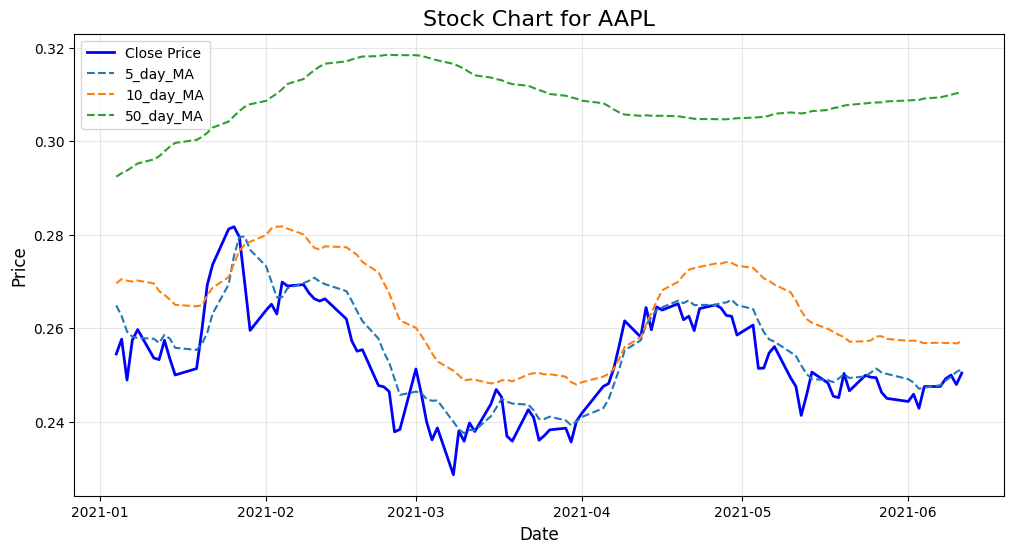

In [10]:
plot_stock_chart(stock_data_tidy, ticker='AAPL', start_date='2021-01-01', end_date='2022-12-31')

In [11]:
stock_data_tidy

,ticker,date,close_adjusted,RSI,5_day_MA,10_day_MA,20_day_MA,50_day_MA,100_day_MA,200_day_MA,...,price_3_days_ago,price_4_days_ago,price_5_days_ago,price_10_days_ago,price_15_days_ago,price_30_days_ago,price_60_days_ago,price_90_days_ago,ticker_encoded,day_of_week
0,A,2000-09-05,0.264907,0.861415,0.267190,0.263481,0.221243,0.243935,0.305796,0.376189,...,41.7206,42.8218,39.8514,41.1225,29.5674,33.6457,48.1779,61.6837,0,1
1,A,2000-09-06,0.255498,0.802317,0.264028,0.263213,0.226976,0.242257,0.304060,0.376823,...,41.4623,41.7206,42.8218,41.1225,29.2276,30.4170,44.8609,60.2427,0,2
2,A,2000-09-07,0.265271,0.793422,0.264555,0.263952,0.233082,0.240753,0.302856,0.377403,...,42.0605,41.4623,41.7206,41.1225,29.5674,29.2276,46.9408,64.8308,0,3
3,A,2000-09-08,0.251599,0.574629,0.262711,0.263684,0.238560,0.238506,0.301684,0.378017,...,42.0129,42.0605,41.4623,40.6127,31.6065,27.6982,46.0504,68.5148,0,4
4,A,2000-09-11,0.238604,0.393577,0.257305,0.262748,0.242921,0.236384,0.299933,0.378527,...,40.7826,42.0129,42.0605,39.7631,38.3221,28.0381,44.8201,62.1935,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22842278,ZYXI,2021-06-07,0.550810,0.732705,0.582282,0.581736,0.582730,0.668157,0.818492,0.879116,...,15.2800,15.6800,15.2200,14.7800,13.8700,16.1800,16.9800,21.7100,7643,0
22842279,ZYXI,2021-06-08,0.563063,0.716218,0.585422,0.587154,0.586742,0.669251,0.819131,0.878953,...,15.6400,15.2800,15.6800,14.6900,13.8200,16.3600,16.8700,20.2900,7643,1
22842280,ZYXI,2021-06-09,0.562363,0.741475,0.591402,0.594646,0.590815,0.670381,0.818896,0.878901,...,15.7300,15.6400,15.2800,14.1300,14.4100,16.2200,16.3300,18.0700,7643,2
22842281,ZYXI,2021-06-10,0.561663,0.700733,0.594542,0.600448,0.595007,0.671556,0.818661,0.879093,...,15.7500,15.7300,15.6400,14.5500,14.2500,16.2600,16.0750,18.1700,7643,3


In [12]:
stock_data_tidy.columns

Index(['ticker', 'date', 'close_adjusted', 'RSI', '5_day_MA', '10_day_MA',
       '20_day_MA', '50_day_MA', '100_day_MA', '200_day_MA', 'MACD',
       'Signal_Line', 'price_1_days_ago', 'price_2_days_ago',
       'price_3_days_ago', 'price_4_days_ago', 'price_5_days_ago',
       'price_10_days_ago', 'price_15_days_ago', 'price_30_days_ago',
       'price_60_days_ago', 'price_90_days_ago', 'ticker_encoded',
       'day_of_week'],
      dtype='object')

In [13]:
# TODO if needed remove big values, since they are mostly outliers
# tickers_to_remove = stock_data_tidy[stock_data_tidy['close_adjusted'] > 10000]['ticker'].unique()

# stock_data_tidy = stock_data_tidy[~stock_data_tidy['ticker'].isin(tickers_to_remove)]

In [14]:
stock_data_tidy = stock_data_tidy.drop(columns=['price_1_days_ago', 'price_2_days_ago',
    'price_3_days_ago', 'price_4_days_ago', 'price_5_days_ago',
    'price_10_days_ago', 'price_15_days_ago', 'price_30_days_ago',
    'price_60_days_ago', 'price_90_days_ago'])

In [15]:
# TODO if all works with scalers for every ticker, remove this

# numerical_columns = [
#     'close_adjusted', 'RSI', '5_day_MA', '10_day_MA',
#     '20_day_MA', '50_day_MA', '100_day_MA', '200_day_MA',
#     'MACD', 'Signal_Line'
# ]


# scaler = MinMaxScaler()

# stock_data_tidy[numerical_columns] = scaler.fit_transform(stock_data_tidy[numerical_columns])

# numerical_columns.extend(['day_of_week', 'ticker_encoded'])

In [16]:
unique_count = stock_data_tidy['ticker'].nunique()

In [17]:
def inverse_transform_predictions(y_pred, ticker):
    # Use the correct scaler for this ticker
    scaler = scalers[ticker]

    # Inverse transform only the first column (close_adjusted)
    y_pred_rescaled = scaler.inverse_transform(
        np.concatenate((np.array(y_pred).reshape(-1,1), np.zeros((len(y_pred), len(numerical_columns) - 1))), axis=1)
    )[:,0]

    return y_pred_rescaled

In [18]:
def preprocess_data(stock_data_tidy, numerical_columns, sequence_length):
    data = stock_data_tidy[numerical_columns].values

    # Create sequences
    X, y = [], []
    for i in range(sequence_length, len(data)):
        X.append(data[i - sequence_length:i])
        y.append(data[i, 0])

    X = np.array(X)
    y = np.array(y)

    return X, y

In [19]:
def create_lstm_model(sequence_length, num_features, lstm_units_1=50, lstm_units_2=50, dropout_rate=0.1):
    """
    Optimized LSTM model for stock price prediction with Additive Attention.
    """
    numerical_input = Input(shape=(sequence_length, num_features), name="numerical_input")

    first_lstm_layer = LSTM(lstm_units_1, return_sequences=True, name="lstm_layer_1", dropout=dropout_rate)(numerical_input)
    normalized_1 = BatchNormalization()(first_lstm_layer)

    second_lstm_layer = LSTM(lstm_units_2, return_sequences=True, name="lstm_layer_2", dropout=dropout_rate)(normalized_1)
    normalized_2 = BatchNormalization()(second_lstm_layer)

    # Attention mechanism
    attention = AdditiveAttention(name="attention_layer")([normalized_2, normalized_2])
    attended = Multiply()([second_lstm_layer, attention])

    flat = Flatten()(attended)

    x = Dense(64, activation='relu', name="dense_1")(flat)

    output = Dense(32, activation='relu', name="dense_2")(x)

    output = Dense(1, activation='linear', name="output")(output)

    model = Model(inputs=numerical_input, outputs=output, name="Optimized_LSTM_Model_with_Attention")
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])

    return model

In [20]:
lstm_model = create_lstm_model(sequence_length=30, num_features=len(numerical_columns))

In [21]:
lstm_model.summary()

Model: "Optimized_LSTM_Model_with_Attention"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ numerical_input           │ (None, 30, 10)         │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_layer_1 (LSTM)       │ (None, 30, 50)         │         12,200 │ numerical_input[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 30, 50)         │            200 │ lstm_layer_1[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_layer_2 (LSTM)       │ (None, 30, 50)         │         20,200 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 30, 50)         │            200 │ lstm_layer_2[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_layer           │ (None, 30, 50)         │             50 │ batch_normalization_1… │
│ (AdditiveAttention)       │                        │                │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply (Multiply)       │ (None, 30, 50)         │              0 │ lstm_layer_2[0][0],    │
│                           │                        │                │ attention_layer[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 1500)           │              0 │ multiply[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 64)             │         96,064 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 32)             │          2,080 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ output (Dense)            │ (None, 1)              │             33 │ dense_2[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 131,027 (511.82 KB)

 Trainable params: 130,827 (511.04 KB)

 Non-trainable params: 200 (800.00 B)

In [22]:
stock_data_tidy = stock_data_tidy.sort_values(by=['ticker', 'date'])

In [23]:
import numpy as np
from numpy.lib.stride_tricks import sliding_window_view

processed_data_path = google_drive_path + 'processed_data/'

def preprocess_grouped_data(stock_data_tidy, numerical_columns, target_column, sequence_length):
    tickers = stock_data_tidy["ticker_encoded"].unique()

    for ticker in tickers:
        ticker_data = stock_data_tidy[stock_data_tidy["ticker_encoded"] == ticker].sort_values(by="date")
        numerical_data = ticker_data[numerical_columns].values

        if(ticker % 1000 == 0):
          print('Processing ', ticker)
        if len(ticker_data) > sequence_length:
            x_ticker = sliding_window_view(numerical_data, window_shape=(sequence_length, len(numerical_columns)))
            x_ticker = x_ticker.reshape(-1, sequence_length, len(numerical_columns))

            y_ticker = ticker_data[target_column].values[sequence_length-1:]

            np.save(os.path.join(processed_data_path, f"x_ticker_{ticker}.npy"), x_ticker)
            np.save(os.path.join(processed_data_path, f"y_ticker_{ticker}.npy"), y_ticker)

In [24]:
if os.path.exists(processed_data_path) and os.path.isdir(processed_data_path):
    has_file = any(os.path.isfile(os.path.join(processed_data_path, item)) for item in os.listdir(processed_data_path))
    if has_file:
        print("There are files in the processed_data_path.")
    else:
      print('Beginning to process the data...\n')
      preprocess_grouped_data(stock_data_tidy, numerical_columns, 'close_adjusted', 30)
else:
    print("The processed_data_path does not exist or is not a directory.")

There are files in the processed_data_path.


In [78]:
x_files = [f for f in os.listdir(processed_data_path) if f.startswith("x_ticker_")]
tickers = [f.split("_")[-1].replace(".npy", "") for f in x_files]
batch_size = 32

def data_generator(tickers, processed_data_path):
    """Yields data for one ticker per epoch."""

    while True:
        for ticker in tickers:
            returned_count = 0
            # Load data for the current ticker
            x_path = os.path.join(processed_data_path, f"x_ticker_{ticker}.npy")
            y_path = os.path.join(processed_data_path, f"y_ticker_{ticker}.npy")

            x_data = np.load(x_path)
            y_data = np.load(y_path)

            # Ensure data is compatible with the batch size
            steps_per_epoch = len(x_data) // batch_size
            x_data = x_data[:steps_per_epoch * batch_size]
            y_data = y_data[:steps_per_epoch * batch_size]

            # Reshape and yield in batches
            for i in range(steps_per_epoch):
                x_batch = x_data[i * batch_size: (i + 1) * batch_size]
                y_batch = y_data[i * batch_size: (i + 1) * batch_size]
                returned_count += len(x_batch)
                yield x_batch, y_batch

In [79]:
tickers.sort()

In [116]:
train_gen = data_generator(tickers, processed_data_path)

In [117]:
early_stopping = EarlyStopping(monitor="loss", patience=30, restore_best_weights=True)

In [118]:
keras.backend.clear_session()

In [91]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Define the checkpoint callback
checkpoint = ModelCheckpoint(
    filepath=google_drive_path + 'lstm_model_epoch_{epoch:02d}.keras',  # Saves model for each epoch
    save_best_only=False,  # Save model at every epoch
    save_weights_only=False,  # Save full model (architecture + weights)
    verbose=1
)

# Train the model with checkpoint callback
lstm_model.fit(
    train_gen,
    steps_per_epoch=40000,
    epochs=200,
    callbacks=[checkpoint, early_stopping],  # Include checkpoint callback
    verbose=2
)

print("Training complete!")


Epoch 1/200

Epoch 1: saving model to drive/MyDrive/DL_Pickles/lstm_model_epoch_01.keras
40000/40000 - 331s - 8ms/step - loss: 3.4231e-04 - mae: 0.0117
Epoch 2/200

Epoch 2: saving model to drive/MyDrive/DL_Pickles/lstm_model_epoch_02.keras
40000/40000 - 581s - 15ms/step - loss: 2.8549e-04 - mae: 0.0105
Epoch 3/200

Epoch 3: saving model to drive/MyDrive/DL_Pickles/lstm_model_epoch_03.keras
40000/40000 - 836s - 21ms/step - loss: 2.5595e-04 - mae: 0.0099
Epoch 4/200

Epoch 4: saving model to drive/MyDrive/DL_Pickles/lstm_model_epoch_04.keras
40000/40000 - 855s - 21ms/step - loss: 2.1875e-04 - mae: 0.0092
Epoch 5/200

Epoch 5: saving model to drive/MyDrive/DL_Pickles/lstm_model_epoch_05.keras
40000/40000 - 902s - 23ms/step - loss: 2.1300e-04 - mae: 0.0089
Epoch 6/200

Epoch 6: saving model to drive/MyDrive/DL_Pickles/lstm_model_epoch_06.keras
40000/40000 - 811s - 20ms/step - loss: 1.7772e-04 - mae: 0.0079
Epoch 7/200

Epoch 7: saving model to drive/MyDrive/DL_Pickles/lstm_model_epoch_07.

KeyboardInterrupt: 

In [92]:
lstm_model.save(google_drive_path + 'lstm_model4_2.keras')

In [133]:
aapl_data = stock_data_tidy[stock_data_tidy.ticker == "FL"]

X = aapl_data[numerical_columns].values
y = aapl_data['close_adjusted'].values

sequence_length = 30  # Assume sequence length
num_features = X.shape[1]

X_sequences = []
y_sequences = []

for i in range(sequence_length, len(X)):
    X_sequences.append(X[i-sequence_length:i])
    y_sequences.append(y[i])

X_sequences = np.array(X_sequences)
y_sequences = np.array(y_sequences)

In [134]:
y_pred = simple_lstm_model.predict(X_sequences)

177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [135]:
y_sequence_rescaled = inverse_transform_predictions(y_sequences, aapl_data.ticker_encoded.unique()[0])
y_pred_rescaled = inverse_transform_predictions(y_pred, aapl_data.ticker_encoded.unique()[0])

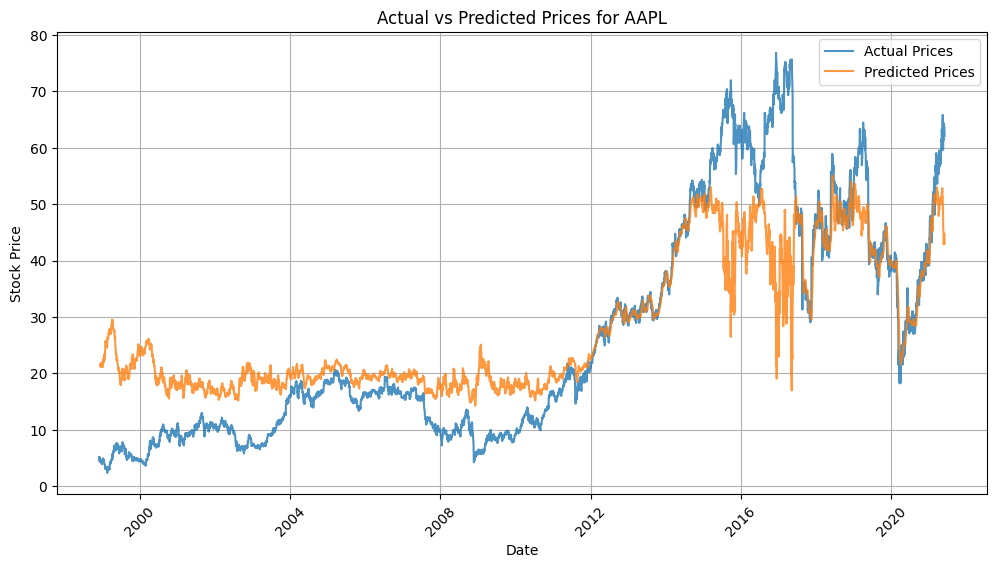

In [136]:
plt.figure(figsize=(12, 6))

# Slice the date column to match the predictions
dates = aapl_data['date'].iloc[sequence_length:].reset_index(drop=True)

y_pred_smoothed = pd.Series(y_pred_rescaled).rolling(window=10).mean()

plt.plot(dates, y_sequence_rescaled, label='Actual Prices', alpha=0.8)
plt.plot(dates, y_pred_smoothed, label='Predicted Prices', alpha=0.8)

plt.title('Actual vs Predicted Prices for AAPL')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.grid()
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()


The model seems to be overfitting the data or maybe failing to generalize it properly. Let's try making a simpler model, to see the bevaiour.

We will decrease the number of LSTM units and increate the dropout

In [111]:
def create_simpler_lstm_model(sequence_length, num_features, lstm_units_1=50, lstm_units_2=25, dropout_rate=0.2):
    """
    Optimized LSTM model for stock price prediction with Additive Attention.
    """
    numerical_input = Input(shape=(sequence_length, num_features), name="numerical_input")

    first_lstm_layer = LSTM(lstm_units_1, return_sequences=True, name="lstm_layer_1", dropout=dropout_rate)(numerical_input)
    normalized_1 = BatchNormalization()(first_lstm_layer)

    second_lstm_layer = LSTM(lstm_units_2, return_sequences=True, name="lstm_layer_2", dropout=dropout_rate)(normalized_1)
    normalized_2 = BatchNormalization()(second_lstm_layer)

    # Attention mechanism
    attention = AdditiveAttention(name="attention_layer")([normalized_2, normalized_2])
    attended = Multiply()([second_lstm_layer, attention])

    flat = Flatten()(attended)

    output = Dense(32, activation='relu', name="dense_2")(flat)

    output = Dense(1, activation='linear', name="output")(output)

    model = Model(inputs=numerical_input, outputs=output, name="Optimized_LSTM_Model_with_Attention")
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])

    return model

In [114]:
simple_lstm_model = create_simpler_lstm_model(
    sequence_length=30,
    num_features=len(numerical_columns))

In [115]:
simple_lstm_model.summary()

Model: "Optimized_LSTM_Model_with_Attention"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ numerical_input           │ (None, 30, 10)         │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_layer_1 (LSTM)       │ (None, 30, 50)         │         12,200 │ numerical_input[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 30, 50)         │            200 │ lstm_layer_1[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_layer_2 (LSTM)       │ (None, 30, 25)         │          7,600 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 30, 25)         │            100 │ lstm_layer_2[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_layer           │ (None, 30, 25)         │             25 │ batch_normalization_3… │
│ (AdditiveAttention)       │                        │                │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply_1 (Multiply)     │ (None, 30, 25)         │              0 │ lstm_layer_2[0][0],    │
│                           │                        │                │ attention_layer[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_1 (Flatten)       │ (None, 750)            │              0 │ multiply_1[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 32)             │         24,032 │ flatten_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ output (Dense)            │ (None, 1)              │             33 │ dense_2[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 44,190 (172.62 KB)

 Trainable params: 44,040 (172.03 KB)

 Non-trainable params: 150 (600.00 B)

In [119]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Define the checkpoint callback
checkpoint = ModelCheckpoint(
    filepath=google_drive_path + 'simple_lstm_model_epoch_{epoch:02d}.keras',  # Saves model for each epoch
    save_best_only=False,  # Save model at every epoch
    save_weights_only=False,  # Save full model (architecture + weights)
    verbose=1
)

# Train the model with checkpoint callback
simple_lstm_model.fit(
    train_gen,
    steps_per_epoch=40000,
    epochs=200,
    callbacks=[checkpoint, early_stopping],  # Include checkpoint callback
    verbose=2
)

print("Training complete!")


Epoch 1/200

Epoch 1: saving model to drive/MyDrive/DL_Pickles/simple_lstm_model_epoch_01.keras
40000/40000 - 334s - 8ms/step - loss: 0.0037 - mae: 0.0347
Epoch 2/200

Epoch 2: saving model to drive/MyDrive/DL_Pickles/simple_lstm_model_epoch_02.keras
40000/40000 - 330s - 8ms/step - loss: 6.8890e-04 - mae: 0.0171
Epoch 3/200

Epoch 3: saving model to drive/MyDrive/DL_Pickles/simple_lstm_model_epoch_03.keras
40000/40000 - 329s - 8ms/step - loss: 5.1886e-04 - mae: 0.0141
Epoch 4/200

Epoch 4: saving model to drive/MyDrive/DL_Pickles/simple_lstm_model_epoch_04.keras
40000/40000 - 328s - 8ms/step - loss: 3.1401e-04 - mae: 0.0114
Epoch 5/200

Epoch 5: saving model to drive/MyDrive/DL_Pickles/simple_lstm_model_epoch_05.keras
40000/40000 - 325s - 8ms/step - loss: 3.1647e-04 - mae: 0.0111
Epoch 6/200

Epoch 6: saving model to drive/MyDrive/DL_Pickles/simple_lstm_model_epoch_06.keras
40000/40000 - 323s - 8ms/step - loss: 2.9032e-04 - mae: 0.0101
Epoch 7/200

Epoch 7: saving model to drive/MyDriv

KeyboardInterrupt: 

In [120]:
simple_lstm_model.save(google_drive_path + 'simple_lstm_model1_1.keras')